# 2. Real Estate Investment Prediction: Exploratory Data Analysis

## 2.1 Introduction

We now have several databases at our disposal. 
- We have a database containing all of the houses for sale in our target area, including information such as their location, price (including tax and HOA), and characteristics;
- We have another database containing 115 homes owned by a corporate entity (called Houses Inc. for this study) including their location, square footage, beds/baths and monthly rent (and we are assuming that they are making a profit on these houses per some capitalization period, which we consider to be monthly ROI);
- Finally we have a database of schools, which contains the school's geographical location, the demographic breakdown, and some indicators of the student's academic success. 


Does Houses Inc. select houses in areas with certain demographics? Does the proximity to a 'good' school versus a 'bad' school affect the rent Houses Inc. can charge? 


## 2.2 Imports

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from fuzzywuzzy import process, fuzz
from turfpy.measurement import boolean_point_in_polygon
import turfpy as turf
from geojson import Point, MultiPolygon, Feature
import shapely
from warnings import filterwarnings
from pyzillow.pyzillow import ZillowWrapper, GetDeepSearchResults
import re
import decimal
import requests
import json
import time

Use a little CSS to make the dataframes throughout the notebook a little more readable. 

In [6]:
%%HTML
<style>.dataframe th, td:first-child{background:#3f577c;font-family:monospace;color:white;border:3px solid white;
text-align:left !important;}#codex{float:right;}</style>

## 2.3 API URL and Headers

In [32]:
url = "https://realty-mole-property-api.p.rapidapi.com/salePrice"
headers = {
    'x-rapidapi-key': "XXXc3aeef556cmsh20d75de481addfbp172719jsn650c4b3122d9",
    'x-rapidapi-host': "XXXrealty-mole-property-api.p.rapidapi.com"
    }

## 2.4 Fuzzywuzzy function

In [8]:
# Later in the notebook, we will use this function to match district names between databases (some use the words
# 'school district', some don't; some names are obsolete and have been replaced by the department of education)
def match_names(array1, array2, lim):
    """
    Function to match two series and produce a match and the score if over a certain threshold, else
    generate a 'none found'
    """
    shape_name = []
    similarity = []

    for i in array1:
        ratio = process.extract(i, array2, scorer=fuzz.partial_ratio, limit=1)
        if ratio[0][1] >= lim:
            shape_name.append(ratio[0][0])
            similarity.append(ratio[0][1])
        else:
            shape_name.append('none found')
            similarity.append('none')
        
        
    return pd.Series(shape_name), pd.Series(similarity)


## 2.5 Load The Data

### 2.5.1 Shape file with geometry of school districts

We have demographics by school, a list of schools for each district, and have access to a shape file with the geometry of the districts. 
What we *don't* have is the school district for each house owned by Houses Inc. We do have the lat-long of each house, however. 
A way to match the house to the district is to place the geometric point of the house inside a polygon of the district.

To start, let's load the shape file with the geometry of the districts. 

In [14]:
# Read in the shape file of district geo info from colorado.data.gov
district_gpd = gpd.read_file('../raw_data/geo_export_972ae359-f768-49c7-9ef8-5465d24f44a8.shp')
district_gpd.head(2)

,abbrev_nam,alt_addres,lgid,lgname,lgstatusid,lgtypeid,mail_addre,mail_city,mail_state,mail_zip,prev_name,source,url,geometry
0,Buena Vista R-31 School District,NA,08900,Buena Vista R-31 School District,1,99,PO Box 2027,Buena Vista,CO,81211,NA,Census TIGER SHP 2014,NA,"POLYGON ((-106.59904 39.03628, -106.59895 39.0..."
1,Burlington RE-6J School District,NA,64929,Burlington RE-6J School District,1,99,PO Box 369,Burlington,CO,80807,NA,Census TIGER SHP 2014,www.burlingtonk12.org,"POLYGON ((-102.43672 39.58525, -102.41964 39.5..."


As mentioned above, we need to standardize the names of the districts across any dataframes which use district as a field. We will use the field, 'lgname' (legal name) instead of 'abbrev_nam', so we can drop the 'abbrev_nam', and 'alt_addres' columns to avoid any confusion. The correct basis for districts for the rest of the project will be the 'lgname' column in the district_gpd dataframe, renamed to 'districtMatch'.

In [15]:
# Drop confusing columns in place
district_gpd.drop(['abbrev_nam', 'alt_addres'], axis=1, inplace=True)

In [20]:
# Rename column
district_gpd.rename(columns = {'lgname':'districtMatch'}, inplace = True)
district_gpd.head(2)

,lgid,districtMatch,lgstatusid,lgtypeid,mail_addre,mail_city,mail_state,mail_zip,prev_name,source,url,geometry
0,08900,Buena Vista R-31 School District,1,99,PO Box 2027,Buena Vista,CO,81211,NA,Census TIGER SHP 2014,NA,"POLYGON ((-106.59904 39.03628, -106.59895 39.0..."
1,64929,Burlington RE-6J School District,1,99,PO Box 369,Burlington,CO,80807,NA,Census TIGER SHP 2014,www.burlingtonk12.org,"POLYGON ((-102.43672 39.58525, -102.41964 39.5..."


In [105]:
houses_inc['districtMatch'].unique()

array(['Brighton 27J School District', 'Adams 12 Five Star Schools',
       'Douglas County RE 1 School District',
       'Cherry Creek 5 School District',
       'Adams-Arapahoe 28J School District',
       'Denver County 1 School District',
       'Jefferson County R-1 School District',
       'Westminster 50 School District', 'Littleton 6 School District',
       'Mapleton 1 School District',
       'St. Vrain Valley RE 1J School District'], dtype=object)

### 2.5.2 Schools data

In [127]:
# read the locally stored csv into a dataframe
schools = pd.read_csv('../data/school_digger.csv')

In [118]:
schools.columns

Index(['schoolid', 'schoolName', 'lowGrade', 'highGrade', 'schoolLevel',
       'rankMovement', 'hasBoundary', 'street', 'city', 'state', 'zip', 'zip4',
       'latitude', 'longitude', 'countyName', 'districtName', 'index',
       'numberOfStudents', 'percentFreeDiscLunch',
       'percentofAfricanAmericanStudents', 'percentofAsianStudents',
       'percentofHispanicStudents', 'percentofWhiteStudents',
       'percentofIndianStudents', 'percentofPacificIslanderStudents',
       'percentofTwoOrMoreRaceStudents', 'pupilTeacherRatio', 'year',
       'point_pair', 'districtMatch', 'similarity'],
      dtype='object')

In [128]:
# Add a point-pair for geographical location
#schools['point_pair'] = schools.apply(lambda x:[x.longitude, x.latitude], axis=1)
#schools.head(2)

In [129]:
# Make a geodataframe from the schools df lat and longitude. 
df = pd.DataFrame(schools[['schoolid', 'latitude', 'longitude']])
schools_gpd = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

In [130]:
# Create the dataframe from the spatial join
merging = gpd.sjoin(schools_gpd, district_gpd[['districtMatch', 'geometry']], how='left', op='within')

<ipython-input-130-0ba35ff23d89>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  merging = gpd.sjoin(schools_gpd, district_gpd[['districtMatch', 'geometry']], how='left', op='within')


In [131]:
# Add the series containing district information to the houses_inc df
schools['districtMatch'] = merging['districtMatch']
schools.drop(['districtName', 'index'], axis=1, inplace=True)
schools.columns

Index(['schoolid', 'schoolName', 'lowGrade', 'highGrade', 'schoolLevel',
       'rankMovement', 'hasBoundary', 'street', 'city', 'state', 'zip', 'zip4',
       'latitude', 'longitude', 'countyName', 'numberOfStudents',
       'percentFreeDiscLunch', 'percentofAfricanAmericanStudents',
       'percentofAsianStudents', 'percentofHispanicStudents',
       'percentofWhiteStudents', 'percentofIndianStudents',
       'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
       'pupilTeacherRatio', 'year', 'districtMatch'],
      dtype='object')

In [132]:
schools['districtMatch'].nunique()

20

In [134]:
# Create a list of all of the districts contained in our list of schools, within our geographical area, and filter the geoframe
# by that list. 
m = district_gpd['districtMatch'].isin(schools.districtMatch)
district_gpd = district_gpd[m]
district_gpd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 20 entries, 12 to 176
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   lgid           20 non-null     object  
 1   districtMatch  20 non-null     object  
 2   lgstatusid     20 non-null     object  
 3   lgtypeid       20 non-null     object  
 4   mail_addre     20 non-null     object  
 5   mail_city      20 non-null     object  
 6   mail_state     20 non-null     object  
 7   mail_zip       20 non-null     object  
 8   prev_name      20 non-null     object  
 9   source         20 non-null     object  
 10  url            20 non-null     object  
 11  geometry       20 non-null     geometry
dtypes: geometry(1), object(11)
memory usage: 2.0+ KB


### 2.5.3 Load Houses Inc. data

In [16]:
# Load houses_inc df resulting from webscraping in section 1, Data Wrangling
houses_inc = pd.read_csv('../data/corporate_properties.csv')

In [17]:
houses_inc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   property_code  134 non-null    int64  
 1   address_1      134 non-null    object 
 2   city           134 non-null    object 
 3   state          134 non-null    object 
 4   zipcode        134 non-null    int64  
 5   beds           134 non-null    int64  
 6   baths          134 non-null    float64
 7   sqft           134 non-null    int64  
 8   market_rent    134 non-null    float64
 9   lat            134 non-null    float64
 10  lng            134 non-null    float64
dtypes: float64(4), int64(4), object(3)
memory usage: 11.6+ KB


In [209]:
houses_inc.head(2)

,property_code,address_1,city,state,zipcode,beds,baths,sqft,market_rent,lat,lng
0,10000753,10627 Kittredge St,Commerce City,CO,80022,3,2.5,1993,2939.0,39.88982,-104.80151
1,10000801,10705 Clermont St,Thornton,CO,80233,3,2.0,1544,2529.0,39.89058,-104.93351


To find the district each house is placed within, we need to generate a geodataframe from this dataframe. 

In [23]:
# Make a geodataframe from the houses, inc lat and longitude. 
df = pd.DataFrame(houses_inc[['property_code', 'lat', 'lng']])
house_gpd = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lng, df.lat))
house_gpd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   property_code  134 non-null    int64   
 1   lat            134 non-null    float64 
 2   lng            134 non-null    float64 
 3   geometry       134 non-null    geometry
dtypes: float64(2), geometry(1), int64(1)
memory usage: 4.3 KB


In [24]:
# Create the dataframe from the spatial join

merging = gpd.sjoin(house_gpd, district_gpd[['districtMatch', 'geometry']], how='left', op='within')

<ipython-input-24-7e7ca67aad80>:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  merging = gpd.sjoin(house_gpd, district_gpd[['districtMatch', 'geometry']], how='left', op='within')


In [25]:
# Add the series containing district information to the houses_inc df
houses_inc['districtMatch'] = merging['districtMatch']
houses_inc.head(2)

,property_code,address_1,city,state,zipcode,beds,baths,sqft,market_rent,lat,lng,point_pair,districtMatch
0,10000753,10627 Kittredge St,Commerce City,CO,80022,3,2.5,1993,2939.0,39.88982,-104.80151,"[-104.80151, 39.88982]",Brighton 27J School District
1,10000801,10705 Clermont St,Thornton,CO,80233,3,2.0,1544,2529.0,39.89058,-104.93351,"[-104.93351, 39.89058]",Adams 12 Five Star Schools


We need to know the approximate value of the houses_inc homes in order to figure out the cost of ownership. Due to the difficulty of using Zillow and getting "zestimates" (Zillow aggressively deters webscraping), we will use a paid API called Realty Mole which has a utility which estimates values. It seems to slightly underestimate the values based on the "zestimate" but it seems to be based on comps. 

In [31]:
# Call API for each row using longitude and latitude of the corporate owned houses. 
# The API has a max call on the data plan, so use sleep to slow it down
print("Start:", time.ctime())
prices = []
for row in houses_inc.itertuples():
    querystring = {'longitude':row.lng, 'latitude':row.lat}
    response = requests.request("GET", url, headers=headers, params=querystring)
    res = json.loads(response.text)
    # Read price out of json and append to list, 'prices'
    prices.append(res['price'])
    time.sleep(1)
print("End:", time.ctime())

Start: Tue Jul 20 15:05:23 2021
End: Tue Jul 20 15:08:29 2021


In [33]:
# Make list a new column in houses_inc df.     
houses_inc['estimatedPrice'] = prices
houses_inc.head()

,property_code,address_1,city,state,zipcode,beds,baths,sqft,market_rent,lat,lng,point_pair,districtMatch,estimatedPrice
0,10000753,10627 Kittredge St,Commerce City,CO,80022,3,2.5,1993,2939.0,39.88982,-104.80151,"[-104.80151, 39.88982]",Brighton 27J School District,471980.00
1,10000801,10705 Clermont St,Thornton,CO,80233,3,2.0,1544,2529.0,39.89058,-104.93351,"[-104.93351, 39.89058]",Adams 12 Five Star Schools,408857.45
2,10000898,10874 Fairfax Way,Thornton,CO,80233,4,2.0,1904,2599.0,39.89348,-104.92838,"[-104.92838, 39.89348]",Adams 12 Five Star Schools,411345.00
3,10000946,10944 Bellaire Way,Thornton,CO,80233,4,2.0,1800,2485.0,39.89548,-104.93625,"[-104.93625, 39.89548]",Adams 12 Five Star Schools,404420.00
4,10001199,11120 Sylvan Pl,Parker,CO,80138,3,2.0,1387,2549.0,39.51228,-104.74424,"[-104.74424, 39.51228]",Douglas County RE 1 School District,545330.00


We need the ROI on the Houses Inc houses. Use the following to estimate ownership costs:
- Annual taxes in Colorado average 0.56%
- Maintenance is estimated at 1.5 times the monthly rent
- Cost of property management in Colorado is currently 8% of the rent collected
- Cost of money, according to a real estate investor who advised me for this project, is 4% of the current property value, regardless of how and when you paid for the property. 
- Real estate investors do not count on property values going up when calculating ROI so that is not included here. 


In [45]:
# Estimate cost of ownership with simple df math
houses_inc['annualTaxes'] = round(houses_inc['estimatedPrice'] * 0.0056, 0)
houses_inc['costofMoney'] = round(houses_inc['estimatedPrice'] * 0.04, 2)
houses_inc['maintenance'] = houses_inc['market_rent'] * 1.5
houses_inc['management'] = houses_inc['market_rent'] * 12 * 0.08
houses_inc['ROI'] = (12 * houses_inc['market_rent'])-(houses_inc['maintenance'] + houses_inc['management'] + houses_inc['annualTaxes'] + houses_inc['costofMoney'])

In [51]:
# how many of House Inc's houses have positive ROI
ROIunderZero = houses_inc[houses_inc['ROI'] <= 0]
ROIunderZero.shape

(8, 19)

Of the 134 houses owned by Houses Inc in this df, only 8 have a negative ROI. 

In [194]:
houses_inc.columns

Index(['property_code', 'address_1', 'city', 'state', 'zipcode', 'beds',
       'baths', 'sqft', 'market_rent', 'lat', 'lng', 'point_pair',
       'districtMatch', 'estimatedPrice', 'annualTaxes', 'costofMoney',
       'maintenance', 'ROI', 'management'],
      dtype='object')

In [206]:
# Write the modified Houses Inc dataframe back to local storage
houses_inc.to_csv('../data/corporate_properties_ROI.csv', index = False, header = True)

### 2.5.4 Houses for sale data

Load the houses for sale data, which was scraped from a denver listings website using the same long/lat we have used for schools, districts, and corporate-owned properties. 

In [72]:
for_sale = pd.read_csv('../data/denverlistings.csv', thousands=',')

In [73]:
for_sale.shape

(99, 17)

There are currently 99 single family homes for sale (under 750k) in this geographical region. 

In [75]:
# Remove the '$' from listPrice, taxes, and hoaFees.
for_sale.taxes = [x.strip('$') for x in for_sale.taxes]
for_sale.taxes = [x.replace(',', '') for x in for_sale.taxes]

# The below method is really cool, but can't be repeated, because it slices off the first character. 
#for_sale.taxes = [x[1:] for x in for_sale.taxes]
# So, instead strip off the '$' using a simple list comp
for_sale.hoaFees = [x.strip('$') for x in for_sale.hoaFees]
for_sale.head()

,address,city,zip,beds,baths,sqft,listPrice,taxes,hoaFees,hoaFreq,lat,lng,district,elementarySchool,middleSchool,highSchool,point_pair
0,4900 W Stanford Avenue,Denver,80236,4.0,3.0,2154,750000,1550,0,NaN,39.635514,-105.050426,Denver 1,Kaiser,Strive Federal,John F. Kennedy,"[-105.05042568, 39.63551445]"
1,1450 Bellaire Street,Denver,80220,3.0,2.0,1946,750000,2530,0,NaN,39.739261,-104.936962,Denver 1,Palmer,Hill,East,"[-104.93696219, 39.73926102]"
2,2820 W 43rd Avenue,Denver,80211,3.0,2.0,1536,750000,2094,70,Monthly,39.775188,-105.022709,Denver 1,Columbian,Bryant-Webster,North,"[-105.02270938, 39.77518792]"
3,20890 Beekman Place,Denver,80249,4.0,4.0,3545,750000,4842,0,Quarterly,39.785374,-104.744527,Denver 1,Waller,McGlone,DCIS at Montbello,"[-104.7445274, 39.78537444]"
4,4800 W Princeton Avenue,Denver,80236,4.0,3.0,2773,750000,2262,30,Annually,39.641188,-105.049271,Denver 1,Kaiser,Henry,John F. Kennedy,"[-105.04927115, 39.64118827]"


In [76]:
# Correct some of the strange data types left over from scraping
for_sale.hoaFees = for_sale.hoaFees.astype(int)
for_sale.taxes = for_sale.taxes.astype(int)
for_sale.dtypes

address              object
city                 object
zip                   int64
beds                float64
baths               float64
sqft                  int64
listPrice             int64
taxes                 int32
hoaFees               int32
hoaFreq              object
lat                 float64
lng                 float64
district             object
elementarySchool     object
middleSchool         object
highSchool           object
point_pair           object
dtype: object

We need to figure out some costs of ownership for houses for sale. Use the same calculations as for the corporate owned houses, but also use HOA where necessary.

In [77]:
for_sale.hoaFreq.unique()

array([nan, 'Monthly', 'Quarterly', 'Annually', 'Semi-Annually'],
      dtype=object)

In [82]:
yearly_hoa = []

for row in for_sale.itertuples():
    x = 0
    if row.hoaFees != 0:
        if row.hoaFreq == 'Monthly':
            x = 12 * row.hoaFees
        if row.hoaFreq == 'Quarterly':
            x = 4 * row.hoaFees
        if row.hoaFreq == 'Semi-Annually':
            x = 2 * row.hoaFees
        if row.hoaFreq == 'Annually':
            x = row.hoaFees
        else:
            x = 0
    x = x + row.taxes
    yearly_hoa.append(x)
for_sale['yearly_hoa'] = yearly_hoa

In [84]:
# Estimate cost of ownership with simple df math
for_sale['annualTaxes'] = round(for_sale['listPrice'] * 0.0056, 0)
for_sale['costofMoney'] = round(for_sale['listPrice'] * 0.04, 2)
#for_sale['maintenance'] = for_sale['market_rent'] * 1.5
#for_sale['management'] = for_sale['market_rent'] * 12 * 0.08
#for_sale['ROI'] = (12 * for_sale['market_rent'])-(for_sale['maintenance'] + for_sale['management'] + for_sale['annualTaxes'] + for_sale['costofMoney'])

Using the average market_rent per square foot for the corporate owned houses for each school district, we can apply rents to these properties for sale. We need to make the school district names match across dataframes. 

In [86]:
# Match the for_sale df 'district' to the district name in the shapefile df of districts.
for_sale['districtMatch'], for_sale['similarity'] = match_names(for_sale.district, district_gpd.districtMatch, 70)

In [89]:
# Drop the 'district' col, keep the districtMatch col. 
for_sale.drop(['district'], axis=1, inplace=True)

## 2.5 Explore the Data

### 2.5.1 Scatter plot of the schools, and houses owned by Houses, Inc.

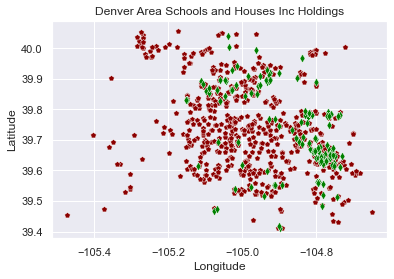

In [226]:
# Start with a scatterplot of the locations of schools.
sns.set()
sns.scatterplot(x='longitude', y='latitude', data=schools,
                color='darkred', marker='p')
sns.scatterplot(x='lng', y='lat', data=houses_inc,
                 color='green', marker='d')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Denver Area Schools and Houses Inc Holdings')
plt.show()

Certainly there is nothing interesting except that houses are near schools, which is a universal truth. Maybe the school district is more important that the location. Let's overlay this on top of the school district. 

<Figure size 720x504 with 0 Axes>

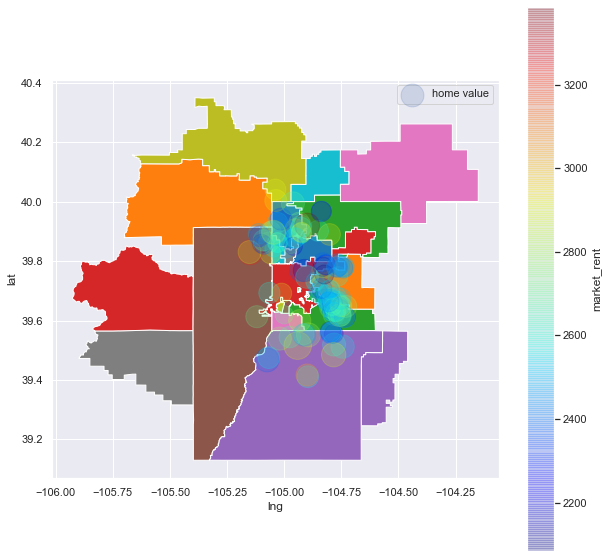

In [147]:
plt.figure(figsize=(10,7))
ax = district_gpd.plot(column='districtMatch', legend=True, figsize=(10,10))

houses_inc.plot(x='lng', y='lat', kind='scatter', alpha=0.2, 
         s= houses_inc['estimatedPrice']/1000, label='home value', ax=ax,
         c= 'market_rent', cmap=plt.get_cmap('jet'), colorbar=True, 
         zorder=5)
plt.legend()
plt.show()

No handles with labels found to put in legend.


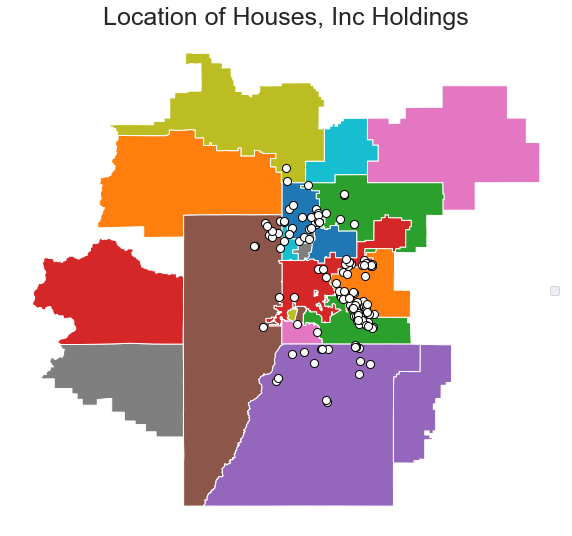

In [205]:
sns.set()
# Plot the district shapefile
ax = district_gpd.plot(column='districtMatch', legend=True, figsize=(10,10))
ax.legend(bbox_to_anchor=(1.0, .5), prop={'size': 12})
ax.set_axis_off()
# Add the house locations
plt.scatter(x=houses_inc.lng, y=houses_inc.lat, c='white', edgecolor = 'black', s=65)
# Add labels and title
plt.title('Location of Houses, Inc Holdings', fontsize=25)
plt.xlabel('longitude')
plt.ylabel('latitude')

# Add grid lines and show the plot
#plt.grid()
plt.show()

### 2.5.3 Plot the House Inc locations over the district map

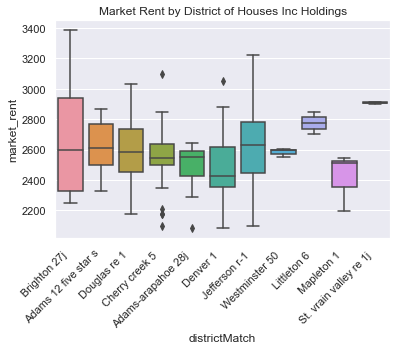

In [246]:
_ = sns.boxplot(x='districtMatch', y='market_rent', data=houses_inc)
plt.title('Market Rent by District of Houses Inc Holdings')
_.set_xticklabels(_.get_xticklabels(), rotation=45, horizontalalignment='right');

### 2.5.4 Houses Inc properties per district, and median rent charged by school district

Now that we have the district information for each house owned by Houses Inc, we can find the average market rent by district and the number of houses owned in each district. 

In [158]:
# Create a pivot table of median rent per district
pivot = houses_inc.pivot_table(index =['districtMatch'], values=['market_rent'],
                       aggfunc ='median')

pivot_valuation = houses_inc.pivot_table(index=['districtMatch'], values=['estimatedPrice'], aggfunc = 'median')
pivot_full = pivot.merge(pivot_valuation, on='districtMatch')

print(pivot_full)

                                        market_rent  estimatedPrice
districtMatch                                                      
Adams 12 Five Star Schools                   2607.5      410101.225
Adams-Arapahoe 28J School District           2550.0      389575.000
Brighton 27J School District                 2595.0      439589.950
Cherry Creek 5 School District               2545.0      387692.250
Denver County 1 School District              2425.0      394354.450
Douglas County RE 1 School District          2585.0      482852.475
Jefferson County R-1 School District         2632.5      439182.475
Littleton 6 School District                  2774.5      414145.000
Mapleton 1 School District                   2510.0      403935.000
St. Vrain Valley RE 1J School District       2907.0      461204.950
Westminster 50 School District               2595.0      381130.000


The district with the highest market rents is St. Vrain, and the lowest is Denver. 

In [190]:
# Create a grouby of houses per district owned by Houses Inc

houses_by_district = houses_inc.groupby("districtMatch")["property_code"].count()                                                                                    
print(houses_by_district)

districtMatch
Adams 12 Five Star Schools                18
Adams-Arapahoe 28J School District        21
Brighton 27J School District               5
Cherry Creek 5 School District            31
Denver County 1 School District           19
Douglas County RE 1 School District       18
Jefferson County R-1 School District      12
Littleton 6 School District                2
Mapleton 1 School District                 3
St. Vrain Valley RE 1J School District     2
Westminster 50 School District             3
Name: property_code, dtype: int64


Most of the houses are in the Cherry Creek district, and the fewest are in Littleton and St. Vrain Valley. That's interesting, because those two districts fetch the highest market rent. 

Let's combine houses_by_district and pivot and make nice chart showing the correlation between market_rents and number of houses. 

In [191]:
houses_by_district = pd.DataFrame(houses_by_district)

In [192]:
houses_by_district.columns

Index(['property_code'], dtype='object')

In [193]:
houses_by_district = pivot_full.join(houses_by_district)
houses_by_district.rename(columns = {'market_rent':'medianRent', 'estimatedPrice':'estcurrentValue', 'property_code':'#propsinDistrict'}, inplace = True)
houses_by_district.head(10)

,medianRent,estcurrentValue,#propsinDistrict
districtMatch,,,
Adams 12 Five Star Schools,2607.5,410101.225,18
Adams-Arapahoe 28J School District,2550.0,389575.000,21
Brighton 27J School District,2595.0,439589.950,5
Cherry Creek 5 School District,2545.0,387692.250,31
Denver County 1 School District,2425.0,394354.450,19
Douglas County RE 1 School District,2585.0,482852.475,18
Jefferson County R-1 School District,2632.5,439182.475,12
Littleton 6 School District,2774.5,414145.000,2
Mapleton 1 School District,2510.0,403935.000,3


In [195]:
# Create a pivot table of ROI per district
pivot_roi = houses_inc.pivot_table(index =['districtMatch'], values=['ROI'],
                       aggfunc ='mean')

In [197]:
houses_by_district = pivot_roi.join(houses_by_district)

In [201]:
houses_by_district['ROIasFractofValue%'] = houses_by_district['ROI'] * 100/houses_by_district['estcurrentValue']
houses_by_district

,ROI,medianRent,estcurrentValue,#propsinDistrict,ROIasFractofValue,ROIasFractofValue%
districtMatch,,,,,,
Adams 12 Five Star Schools,5508.790000,2607.5,410101.225,18,0.013433,1.343276
Adams-Arapahoe 28J School District,6082.560000,2550.0,389575.000,21,0.015613,1.561332
Brighton 27J School District,4468.980000,2595.0,439589.950,5,0.010166,1.016625
Cherry Creek 5 School District,6395.707097,2545.0,387692.250,31,0.016497,1.649687
Denver County 1 School District,4820.233158,2425.0,394354.450,19,0.012223,1.222310
Douglas County RE 1 School District,1659.479444,2585.0,482852.475,18,0.003437,0.343682
Jefferson County R-1 School District,4376.342500,2632.5,439182.475,12,0.009965,0.996475
Littleton 6 School District,7417.930000,2774.5,414145.000,2,0.017911,1.791143
Mapleton 1 School District,5550.550000,2510.0,403935.000,3,0.013741,1.374120


<ipython-input-153-5a84d7f18269>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(houses_by_district.index, rotation=45, horizontalalignment='right')


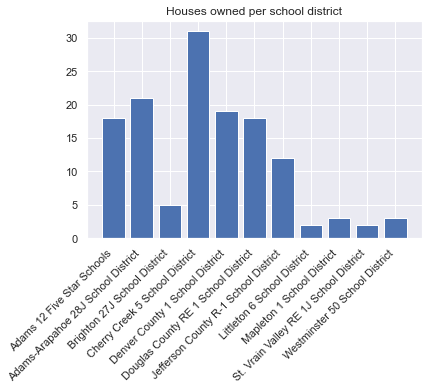

In [153]:
fig, ax = plt.subplots()
ax.bar(houses_by_district.index, houses_by_district['property_code'])
ax.set_xticklabels(houses_by_district.index, rotation=45, horizontalalignment='right')
plt.title('Houses owned per school district')
# ax.bar(houses_by_district.index, houses_by_district['market_rent'])
plt.show();

We have the demographic information by school, the district by school, the district by houses both for sale and owned by Houses Inc. Let's aggregate the demographic data by district between the schools and a new, district_demographics dataframe. 

In [251]:
# Have the schools column names handy
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   schoolid                          569 non-null    int64  
 1   schoolName                        569 non-null    object 
 2   lowGrade                          569 non-null    object 
 3   highGrade                         569 non-null    int64  
 4   schoolLevel                       569 non-null    object 
 5   rankMovement                      569 non-null    float64
 6   hasBoundary                       569 non-null    bool   
 7   street                            569 non-null    object 
 8   city                              569 non-null    object 
 9   state                             569 non-null    object 
 10  zip                               569 non-null    int64  
 11  zip4                              555 non-null    float64
 12  latitude

In [252]:
# New df from the schools df, with only demographics and removing individual locations. 
# Maintain location information within schools df.

district_demographics = schools[['districtMatch', 'rankMovement', 'numberOfStudents', 'percentFreeDiscLunch',
       'percentofAfricanAmericanStudents', 'percentofAsianStudents',
       'percentofHispanicStudents', 'percentofWhiteStudents',
       'percentofIndianStudents', 'percentofPacificIslanderStudents',
       'percentofTwoOrMoreRaceStudents']]

In [253]:
# Take a look at the df we just created
district_demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   districtMatch                     569 non-null    object 
 1   rankMovement                      569 non-null    float64
 2   numberOfStudents                  569 non-null    float64
 3   percentFreeDiscLunch              568 non-null    float64
 4   percentofAfricanAmericanStudents  568 non-null    float64
 5   percentofAsianStudents            568 non-null    float64
 6   percentofHispanicStudents         568 non-null    float64
 7   percentofWhiteStudents            568 non-null    float64
 8   percentofIndianStudents           568 non-null    float64
 9   percentofPacificIslanderStudents  568 non-null    float64
 10  percentofTwoOrMoreRaceStudents    568 non-null    float64
dtypes: float64(10), object(1)
memory usage: 49.0+ KB


We have a breakdown of percentages of each race by district. Are these percentages reliable? Before we use this data for analysis, does the data make sense? 

In [254]:
# Add together the percentages and see if it adds to about 100%
district_demographics['totalpercent'] = schools.apply(lambda row: row['percentofAfricanAmericanStudents' : 'percentofTwoOrMoreRaceStudents'].sum(),axis=1)

<ipython-input-254-d60c276f12a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_demographics['totalpercent'] = schools.apply(lambda row: row['percentofAfricanAmericanStudents' : 'percentofTwoOrMoreRaceStudents'].sum(),axis=1)


In [255]:
# Are there any schools where it does not add to one hundred percent-ish
district_demographics[district_demographics['totalpercent'] <= 99]

,districtMatch,rankMovement,numberOfStudents,percentFreeDiscLunch,percentofAfricanAmericanStudents,percentofAsianStudents,percentofHispanicStudents,percentofWhiteStudents,percentofIndianStudents,percentofPacificIslanderStudents,percentofTwoOrMoreRaceStudents,totalpercent
522,Mapleton 1,45.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


It looks there is one school without demographic information, let's delete that school. 

In [256]:
# Keep only schools with a total percentage of over 99%
district_demographics = district_demographics[district_demographics['totalpercent'] >= 99]
district_demographics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568 entries, 0 to 568
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   districtMatch                     568 non-null    object 
 1   rankMovement                      568 non-null    float64
 2   numberOfStudents                  568 non-null    float64
 3   percentFreeDiscLunch              568 non-null    float64
 4   percentofAfricanAmericanStudents  568 non-null    float64
 5   percentofAsianStudents            568 non-null    float64
 6   percentofHispanicStudents         568 non-null    float64
 7   percentofWhiteStudents            568 non-null    float64
 8   percentofIndianStudents           568 non-null    float64
 9   percentofPacificIslanderStudents  568 non-null    float64
 10  percentofTwoOrMoreRaceStudents    568 non-null    float64
 11  totalpercent                      568 non-null    float64
dtypes: float

In [257]:
# Create pivot table adding together all of the percentages; this is a clumsy way to do it. 

districtpivot = district_demographics.pivot_table(index =['districtMatch'], values=['rankMovement', 'numberOfStudents', 'percentFreeDiscLunch',
       'percentofAfricanAmericanStudents', 'percentofAsianStudents',
       'percentofHispanicStudents', 'percentofWhiteStudents',
       'percentofIndianStudents', 'percentofPacificIslanderStudents',
       'percentofTwoOrMoreRaceStudents'],
                       aggfunc ='sum')

In [258]:
districtpivot.head()

,numberOfStudents,percentFreeDiscLunch,percentofAfricanAmericanStudents,percentofAsianStudents,percentofHispanicStudents,percentofIndianStudents,percentofPacificIslanderStudents,percentofTwoOrMoreRaceStudents,percentofWhiteStudents,rankMovement
districtMatch,,,,,,,,,,
Adams 12 five star s,31932.0,2037.58,82.02,203.19,2021.06,23.51,6.12,142.71,1821.45,-1006.0
Adams 14,5663.0,748.52,21.47,1.26,768.19,4.15,1.14,9.13,94.67,-50.0
Adams-arapahoe 28j,30729.0,3345.76,703.93,227.14,2387.96,31.93,46.03,261.62,641.48,-1693.0
Boulder valley re 2,26914.0,985.34,44.15,203.30,899.35,13.02,4.35,252.01,2883.88,-515.0
Brighton 27j,12897.0,792.52,39.63,52.64,967.28,5.52,3.13,53.98,677.78,-865.0


In [259]:
# Get the school counts per district, then normalize the percentages. 
schoolcount = schools.groupby("districtMatch")["schoolid"].count()
districts_df = pd.merge(districtpivot, schoolcount, on = "districtMatch", how = "outer")

district_demo_final = districts_df.loc[:,"percentFreeDiscLunch":"rankMovement"].div(districts_df["schoolid"], axis=0)
district_demo_final.head()

,percentFreeDiscLunch,percentofAfricanAmericanStudents,percentofAsianStudents,percentofHispanicStudents,percentofIndianStudents,percentofPacificIslanderStudents,percentofTwoOrMoreRaceStudents,percentofWhiteStudents,rankMovement
districtMatch,,,,,,,,,
Adams 12 five star s,47.385581,1.907442,4.725349,47.001395,0.546744,0.142326,3.318837,42.359302,-23.395349
Adams 14,83.168889,2.385556,0.140000,85.354444,0.461111,0.126667,1.014444,10.518889,-5.555556
Adams-arapahoe 28j,77.808372,16.370465,5.282326,55.533953,0.742558,1.070465,6.084186,14.918140,-39.372093
Boulder valley re 2,22.914884,1.026744,4.727907,20.915116,0.302791,0.101163,5.860698,67.066977,-11.976744
Brighton 27j,44.028889,2.201667,2.924444,53.737778,0.306667,0.173889,2.998889,37.654444,-48.055556


I would be interested in seeing a correlation heatmap after the houses_inc database has been joined to the demographics information. Let's join 'district_demo_final' to houses_inc on the district. First, we need to add a new column to 'district_demo_final' in order to combine them (right now district name is an index).

In [260]:
# reset index on 'district_demo_final'
district_demo_final.reset_index(inplace=True)
district_demo_final.head(2)

,districtMatch,percentFreeDiscLunch,percentofAfricanAmericanStudents,percentofAsianStudents,percentofHispanicStudents,percentofIndianStudents,percentofPacificIslanderStudents,percentofTwoOrMoreRaceStudents,percentofWhiteStudents,rankMovement
0,Adams 12 five star s,47.385581,1.907442,4.725349,47.001395,0.546744,0.142326,3.318837,42.359302,-23.395349
1,Adams 14,83.168889,2.385556,0.140000,85.354444,0.461111,0.126667,1.014444,10.518889,-5.555556


In [144]:
df1 = pd.concat([houses_inc, district_demo_final], axis=1)
df1.drop(['lat', 'lng'],
               axis = 1, inplace=True)
df1.columns

Index(['property_code', 'address_1', 'city', 'state', 'zipcode', 'beds',
       'baths', 'sqft', 'market_rent', 'point_pair', 'districtMatch',
       'districtMatch', 'percentFreeDiscLunch',
       'percentofAfricanAmericanStudents', 'percentofAsianStudents',
       'percentofHispanicStudents', 'percentofIndianStudents',
       'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
       'percentofWhiteStudents', 'rankMovement'],
      dtype='object')

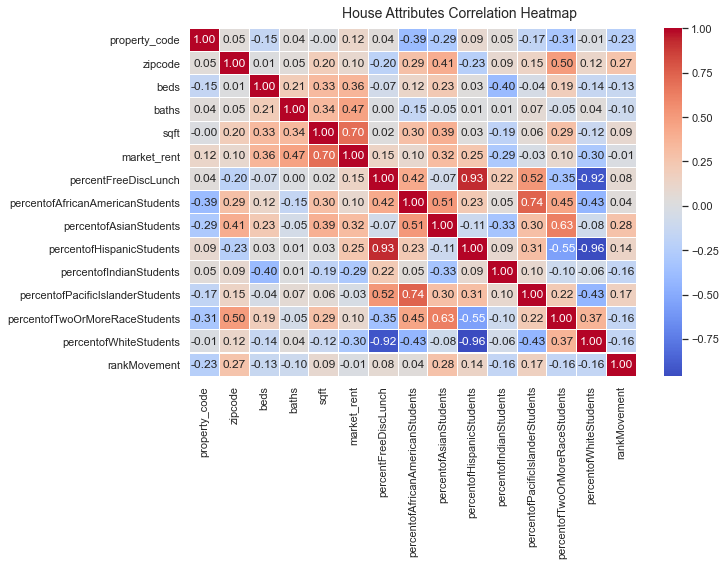

In [145]:
f, ax = plt.subplots(figsize=(10, 6))
corr = df1.corr()
hm = sns.heatmap(round(corr, 2), annot=True, ax=ax, cmap = "coolwarm", fmt='.2f', linewidth=.05)
f.subplots_adjust(top=0.93)
t = f.suptitle('House Attributes Correlation Heatmap', fontsize=14)

In [146]:
houses_by_district.head()

,market_rent,property_code
districtMatch,,
Adams 12 five star s,2615.0,17
Adams-arapahoe 28j,2550.0,20
Brighton 27j,2595.0,5
Cherry creek 5,2545.0,30
Denver 1,2438.0,18


In [147]:
houses_by_district.reset_index(inplace=True)

In [148]:
houses_by_district.head()

,districtMatch,market_rent,property_code
0,Adams 12 five star s,2615.0,17
1,Adams-arapahoe 28j,2550.0,20
2,Brighton 27j,2595.0,5
3,Cherry creek 5,2545.0,30
4,Denver 1,2438.0,18


In [149]:
houses_by_district.rename(columns={'property_code':'Num_of_houses'}, inplace=True)
houses_by_district.head()

,districtMatch,market_rent,Num_of_houses
0,Adams 12 five star s,2615.0,17
1,Adams-arapahoe 28j,2550.0,20
2,Brighton 27j,2595.0,5
3,Cherry creek 5,2545.0,30
4,Denver 1,2438.0,18


In [150]:
district_demo_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   districtMatch                     19 non-null     object 
 1   percentFreeDiscLunch              19 non-null     float64
 2   percentofAfricanAmericanStudents  19 non-null     float64
 3   percentofAsianStudents            19 non-null     float64
 4   percentofHispanicStudents         19 non-null     float64
 5   percentofIndianStudents           19 non-null     float64
 6   percentofPacificIslanderStudents  19 non-null     float64
 7   percentofTwoOrMoreRaceStudents    19 non-null     float64
 8   percentofWhiteStudents            19 non-null     float64
 9   rankMovement                      19 non-null     float64
dtypes: float64(9), object(1)
memory usage: 1.6+ KB


MAYBE DO THIS IN THE FUTURE: Houses Inc. only has houses in *some* of the districts, but not having houses is also interesting. So, let's add the missing disricts to the houses_by_districts df. 

In [151]:
df2 = pd.merge(houses_by_district, district_demo_final, on='districtMatch', how='outer')

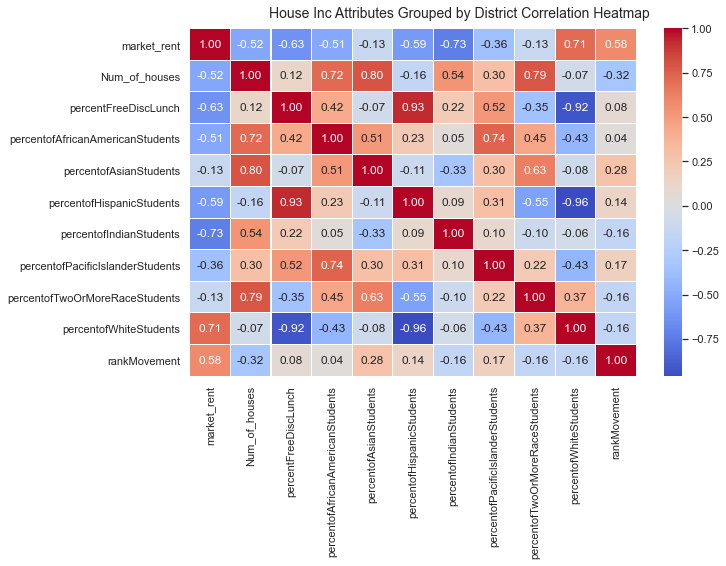

In [152]:
f, ax = plt.subplots(figsize=(10, 6))
corr = df2.corr()
hm = sns.heatmap(round(corr, 2), annot=True, ax=ax, cmap = "coolwarm", fmt='.2f', linewidth=.05)
f.subplots_adjust(top=0.93)
t = f.suptitle('House Inc Attributes Grouped by District Correlation Heatmap', fontsize=14)

In [153]:
#import requests

#url = "https://zillow-com1.p.rapidapi.com/property"

#querystring = {"zpid":"2080998890"}

#headers = {
#    'x-rapidapi-key': "c3aeef556cmsh20d75de481addfbp172719jsn650c4b3122d9",
#    'x-rapidapi-host': "zillow-com1.p.rapidapi.com"
#    }

#response = requests.request("GET", url, headers=headers, params=querystring)

#print(response.text)

In [261]:
#from selenium import webdriver
#from webdriver_manager.chrome import ChromeDriverManager

#d = webdriver.Chrome(ChromeDriverManager().install())
#d.get('https://www.zillow.com/homedetails/5841-Round-Meadow-Rd-Hidden-Hills-CA-91302/19882656_zpid/')
#result = re.findall('(?<=Home Value:\s)\$[\d,\s]+', d.page_source)[0]
#print(result)

In [156]:
#zestimate = []
#for row in houses_inc.itertuples():
#    address = row.address_1
#    zipcode = row.zipcode
#    deep_search_response = zillow_data.get_deep_search_results(address,zipcode)
#    zestimate.append(GetDeepSearchResults(deep_search_response))
#houses_inc['zestimate'] = zestimate
    

471980


In [ ]:
res